# Numerical model of a mediated Glucose Oxidase electrode 

Here we will solve the material balance for an electrode comprising the enzyme glucose oxidase co-immobilized in a hydrogel with the redox polymer mediator poly{N-vinylimidazole [Os(bipyridine)<sub>2</sub>Cl]<sup>+/2+</sup>}. 

$$ -\frac{dN_M}{dx}= D_M\frac{d^2M}{dx^2}=\frac{\nu_S k_{cat} E M S}{K_M S + K_S M + MS} $$    
$$ -\frac{dN_S}{dx}= D_S\frac{d^2S}{dx^2}=\frac{\nu_M k_{cat} E M S}{K_M S + K_S M + MS} $$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scikits.bvp_solver
from scipy.interpolate import interp1d

### Parameters

Parameters are taken from Ref. 1 and 2 and are typical of that system.

In [3]:
DA = 2.18e-9       # Diffusivity of the mediator in cm2/s
DS = 7e-6          # Diffusivity of the substrate (glucose) in hydrogel in cm2/s (Literature value from Calvo's 2005 paper)
ET   = 17.96e-6    # Total enzyme concentration in mol/cm3 ---> To convert in to mM multiply by 1e6
ST   = 50e-6       # Total bulk substrate concentration in mol/cm3
Ao   = 659.7e-6    # Total mediator concentration in mol/cm3 from CV integration
kcat = 17.3        # Turn over number in s-1
kA   = 212e3       # second order rate constant for mediator in cm3/mol/s ---> To convert in to M-1 s-1 multiply by 1e-3           
Ks   = 12.3e-6     # Michaelis constant for substrate in mol/cm3 ---> To convert in to mM multiply by 1e6
vm = 1.             # Stoichiometric coeff. of mediator
vs = 0.5           # Stoichiometric coeff. of substrate
U = 0.43          # Reversible potential of the mediator in volts re:SHE
V  = 0.6           # Fixed potential of the system in volts re:SHE
n  = 1.             # Number of electrons transfered at the elecrode surface
R  = 8.314         # Gas constant in J/mol/K
F  = 96485.4       # Faraday's constant in C/mol
T  = 313           # Temperature of the system in deg K
L  = 1e-4          # Hydrogel film thickness in cm
k     = 1.          # Partition coefficient of glucose and oxygen into the hydrogel film from the solution

### Nondimensionalization

We nondimensionalize the system according to the scheme of Ref. 2

In [4]:
kappa=L*sqrt(vm*kA*ET/DA)
eta=(vm*DS*kA*Ks)/(vs*DA*kcat)
gamma=(kA*Ao*Ks)/(kcat*ST)
mu=(ST/Ks)

eps = (n * F * (V-U))/(R*T)    # From the Nernst equation
ae = 1/(1+exp(-eps))            # Dimensionless potential boundary condition at the electrode surface from the Nernst eqn


### Numerical Solution

We will solve this problem numerically using the python package [bvp_solver](https://pypi.python.org/pypi/scikits.bvp_solver)

In [5]:
def deq(x,z):  # z=[a(x) va(x) s(x) vs(x)];

    a, va, s, vs = z

    Ra= kappa**2*a*s/(gamma*a*(1+mu*s)+s) * (a >= 0) * (s >= 0)
    dvadx= Ra
    dadx= va
    
    dvsdx= gamma/eta*Ra
    dsdx= vs
    
    dzdx= array([dadx,dvadx,dsdx,dvsdx]); return dzdx

In [6]:
def bc(z0,z1):

    a0, va0, s0, vs0 = z0
    a1, va1, s1, vs1 = z1
       
    res= ( array([  a0 - 1/(1+exp(-eps)),      # Nernst BC on a at electrode-film interface
                   vs0 ]),                      # Zero flux BC on s at electrode-film interface
    
           array([ va1,                        # Zero flux BC on a at film-solution interface
                    s1 - 1 ] ) )               # Concentration BC on s at film-solution interface

    return res

In [7]:
problem = scikits.bvp_solver.ProblemDefinition(num_ODE = 4,
                                      num_parameters = 0,
                                      num_left_boundary_conditions = 2,
                                      boundary_points = (0, 1),
                                      function = deq,
                                      boundary_conditions = bc)

In [8]:
solution = scikits.bvp_solver.solve(problem,
                            solution_guess = (1,0,1,0), trace=1 )

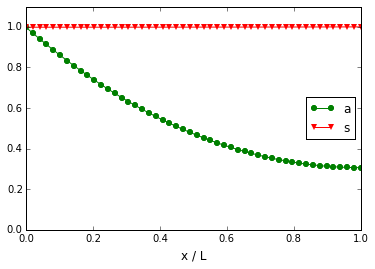

In [9]:
x = linspace(0,1)
y=solution(x)

a=y[0,:]
s=y[2,:]

plot(x,a,'-og')
plot(x,s,'-vr')
legend(['a','s'],loc='center right')
xlabel('x / L')
ylim((0,1.1))

show()

### Rajendran Analytical Model

Rajendran ([Electrochimica Acta 147, p678, 2014](http://linkinghub.elsevier.com/retrieve/pii/S0013468614018209))

In [10]:
E=ET
Km=kcat/kA
Ms=Ao

ns=vs
nm=vm
Dm=DA

In [11]:
Ss=1
phi=  (ns/nm)*kcat*E*Ss / ( ae*Ms*Ss + ae*Ks*Ms + Km*Ss)

The following is the steady-state part of Eq. 26 from the reference. It can be derived by assuming the reaction rate is linearly dependent on the mediator concentraiton, leading to a homogeneous equation with constant coefficients.

In [12]:
def mf(x,Ss):
    phi=  (ns/nm)*kcat*E*Ss / ( ae*Ms*Ss + ae*Ks*Ms + Km*Ss)
        
    mf= ae*cosh(sqrt(phi/Dm)*(x-L)) / cosh(sqrt(phi/Dm)*L)
    return mf

In [13]:
xraj=linspace(0,L)
mraj=mf(xraj,1)

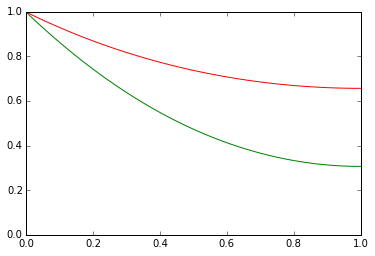

In [14]:
plot(xraj/L,mraj,x,a)
ylim((0,1))
show()

There is disagreement between these results, due to the first-order assumption in the analytical case.

## Polarization Curve

The above numerical treatment can be enclosed in a function to calculate a polarization curve

In [27]:
def polcurve(V,ST,L):
    
    kappa=L*sqrt(vm*kA*ET/DA)
    eta=(vm*DS*kA*Ks)/(vs*DA*kcat)
    gamma=(kA*Ao*Ks)/(kcat*ST)
    mu=(ST/Ks)

    eps = (n * F * (V-U))/(R*T)    # From the Nernst equation
    ae = 1/(1+exp(-eps))            # Dimensionless potential boundary condition at the electrode surface from the Nernst eqn


    def deq(x,z):  # z=[a(x) va(x) s(x) vs(x)];

        a, va, s, vs = z

        Ra= kappa**2*a*s/(gamma*a*(1+mu*s)+s) * (a >= 0) * (s >= 0)
        dvadx= Ra
        dadx= va

        dvsdx= gamma/eta*Ra
        dsdx= vs

        dzdx= array([dadx,dvadx,dsdx,dvsdx]); return dzdx


    def bc(z0,z1):

        a0, va0, s0, vs0 = z0
        a1, va1, s1, vs1 = z1

        res= ( array([  a0 - 1/(1+exp(-eps)),      # Nernst BC on a at electrode-film interface
                       vs0 ]),                      # Zero flux BC on s at electrode-film interface

               array([ va1,                        # Zero flux BC on a at film-solution interface
                        s1 - 1 ] ) )               # Concentration BC on s at film-solution interface

        return res

    problem = scikits.bvp_solver.ProblemDefinition(num_ODE = 4,
                                          num_parameters = 0,
                                          num_left_boundary_conditions = 2,
                                          boundary_points = (0, 1),
                                          function = deq,
                                          boundary_conditions = bc)
    
    solution = scikits.bvp_solver.solve(problem,
                            solution_guess = (1,0,1,0), trace=1 )

    x = linspace(0,1)
    y=solution(x)
    icd=-n*F/vm*DA*Ao/L*y[1,0]
    
    return icd

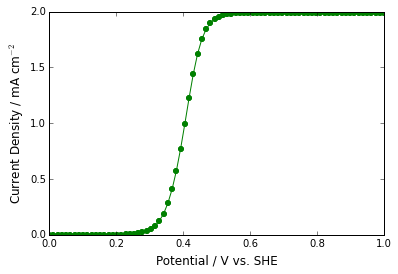

In [73]:
V=linspace(0,1,80)
pv=vectorize(polcurve)
icd=pv(V,ST,L)
plot(V,icd*1000,'-og')
xlabel('Potential / V vs. SHE')
ylabel('Current Density / mA cm$^{-2}$')

## Porous electrode model

### New parameters:

In [17]:
Lp= 100e-4   # cm, electrode thickness
a= 0.16e4    # cm^-1, carbon surface area per unit volume
eps=0.7      # porosity
tp= 2*L/(a*Lp) # Effective thickness of hydrogel film due to roughness a*Lp, with loading L doubled

DSe= DS*eps**1.5;    # Effective diffusivity of substrate due to porosity, eps (Bruggeman relation)

In [20]:
def porous(V,S0):
    
    # We first create a lookup table, Rp(Sv) for local glucose consumption rate 
    # as a function of glucose concentration at this potential
    
    Sv=ST*logspace(-6,2,81)
    jS=pv(V,Sv,tp) * a * vs / n / F
    Rp= interp1d(Sv,jS)
    
    def deq(y,u):  # u=[s(y) vs(y)];

        S, vS = u

        dvSdy= Rp(S)/DSe
        dSdy= vS

        dudy= array([dSdy, dvSdy]); return dudy
    
    def bc(uL,uR):

        SL, vSL = uL
        SR, vSR = uR


        res= ( array([ vSL ]), array([ SR - S0 ] ) )               # Concentration BC on s at film-solution interface

        return res


    problem = scikits.bvp_solver.ProblemDefinition(num_ODE = 2,
                                          num_parameters = 0,
                                          num_left_boundary_conditions = 1,
                                          boundary_points = (0, Lp),
                                          function = deq,
                                          boundary_conditions = bc)
    
    solution = scikits.bvp_solver.solve(problem,
                            solution_guess = (S0,0), trace=1 )

    x = linspace(0,Lp)
    y=solution(x)
    icd=+n*F/vs*DSe*y[1,-1]
    
    return icd


In [22]:
icd= porous(1,ST)
icd

0.0039828162816270924

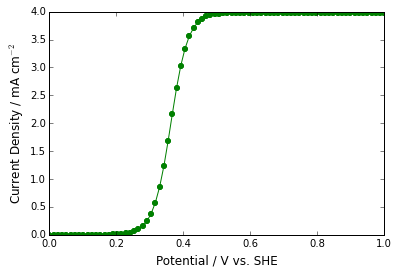

In [72]:
porv=vectorize(porous)
icd=porv(V,ST)
plot(V,icd*1000,'-og')
xlabel('Potential / V vs. SHE')
ylabel('Current Density / mA cm$^{-2}$')

## Cell Polarization

For cell polarization, we define a cathode and calculate its polarization curve.  We then match current densities and calculate overall cell polarization. With this approach, we neglect transport limitations external to the electrodes.

In [63]:
def catcurve(V,ST,L):
    
    kcat=100
    n=4
    vm=4
    vs=1
    U = 0.8
    
    kappa=L*sqrt(vm*kA*ET/DA)
    eta=(vm*DS*kA*Ks)/(vs*DA*kcat)
    gamma=(kA*Ao*Ks)/(kcat*ST)
    mu=(ST/Ks)

    eps = -(n * F * (V-U))/(R*T)    # From the Nernst equation
    ae = 1/(1+exp(-eps))            # Dimensionless potential boundary condition at the electrode surface from the Nernst eqn


    def deq(x,z):  # z=[a(x) va(x) s(x) vs(x)];

        a, va, s, vs = z

        Ra= kappa**2*a*s/(gamma*a*(1+mu*s)+s) * (a >= 0) * (s >= 0)
        dvadx= Ra
        dadx= va

        dvsdx= gamma/eta*Ra
        dsdx= vs

        dzdx= array([dadx,dvadx,dsdx,dvsdx]); return dzdx


    def bc(z0,z1):

        a0, va0, s0, vs0 = z0
        a1, va1, s1, vs1 = z1

        res= ( array([  a0 - 1/(1+exp(-eps)),      # Nernst BC on a at electrode-film interface
                       vs0 ]),                      # Zero flux BC on s at electrode-film interface

               array([ va1,                        # Zero flux BC on a at film-solution interface
                        s1 - 1 ] ) )               # Concentration BC on s at film-solution interface

        return res

    problem = scikits.bvp_solver.ProblemDefinition(num_ODE = 4,
                                          num_parameters = 0,
                                          num_left_boundary_conditions = 2,
                                          boundary_points = (0, 1),
                                          function = deq,
                                          boundary_conditions = bc)
    
    solution = scikits.bvp_solver.solve(problem,
                            solution_guess = (1,0,1,0), trace=1 )

    x = linspace(0,1)
    y=solution(x)
    icd=-n*F/vm*DA*Ao/L*y[1,0]
    
    return icd

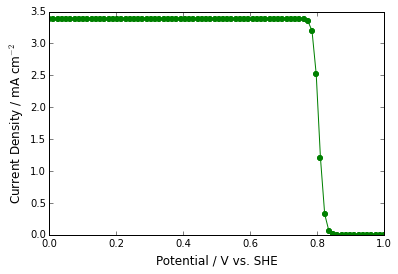

In [74]:
STc=1e-6
cv=vectorize(catcurve)
icd_cat=cv(V,STc,L)
plot(V,icd_cat*1000,'-og')
xlabel('Potential / V vs. SHE')
ylabel('Current Density / mA cm$^{-2}$')

In [99]:
pv_i=interp1d(icd,V)
cv_i= interp1d(icd_cat,V)
V_cell=cv_i(icell)-pv_i(icell)

In [89]:
imax= amin(amax(array([icd,icd_cat]),axis=1))
icell=imax*logspace(-3,0)

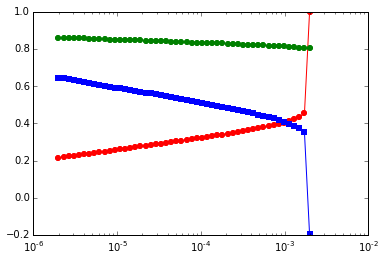

In [102]:
semilogx(icell,pv_i(icell),'o-',icell,cv_i(icell),'o-',icell,V_cell,'s-')